# **MLB Wins By Most Hits or Scoring First**

I played softball for about 15 years and had a coach that always used to say:
* Whoever scores first wins the game; and
* Whoever has the most hits wins the game

So, are these both true? Is one more true than the other? I want to test these assumptions with multiple years of MLB data. 

When the assumption is identified that is more likely to be true (i.e., one situation occurred more frequently than the other), I want to group this data by team to identify if there are differences by team. 

I also want to understand if there is a correlation between wins overall and winning due to having the most hits or scoring first. In other words, are the teams that have more wins from having the most hits or scoring first more likely to have more wins overall?

# Table of Contents

* [Importing Libraries](#lib)
* [Setting the Color Scheme](#color)
* [Loading Data](#data)
* [Manipulating the Innings Data](#inn)
* [Manipulating the Games Data](#gam)
* [Creating First Scores and Most Hits Data](#sc_hit)
* [Did Teams that Won Score First?](#sc_first)
* [Did Teams that Won Have the Most Hits?](#hit_first)
* [Are Results Different for Each Team?](#team)
* [Bivariate Analysis](#biv)
* [Conclusions](#con)


# Importing Libraries <a class="anchor"  id="lib"></a>
Importing the libraries required for this analysis.

In [1]:
#To manipulate data, create dataframes
import pandas as pd
#For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
#For calculating the R^2 value of a line
from scipy import stats

# Setting the Color Scheme <a class="anchor"  id="color"></a>
Using the MLB color scheme for the visualizations for this analysis.

In [2]:
#MLB logo color scheme
mlb_blue = '#002D72' 
mlb_red = '#D50032' 
mlb_colors = [mlb_blue, mlb_red]

# Create a MLB color palette
mlb_palette = sns.diverging_palette(258.7, 8.6, s=75, l=50, sep=1, n=30, center='light', as_cmap=False)


# Loading Data <a class="anchor"  id="data"></a>
The files come from the [MLB Game Data](https://www.kaggle.com/datasets/josephvm/mlb-game-data) dataset.

In [3]:
#Reading the needed csv files
games_df = pd.read_csv('/kaggle/input/mlb-game-data/games.csv')
inning_df = pd.read_csv('/kaggle/input/mlb-game-data/inningHighlights.csv')

In [4]:
#Previewing games_df
games_df.head(5)

,Game,away,away-record,awayaway-record,home,home-record,homehome-record,away-score,home-score,postseason info,...,LOSS - Pitcher - Id,LOSS - Pitcher - Name,LOSS - Pitcher - AbbrName,LOSS - Pitcher - Record,SAVE - Pitcher - Stats,SAVE - Pitcher - Id,SAVE - Pitcher - Name,SAVE - Pitcher - AbbrName,SAVE - Pitcher - Record,Extra Innings
0,360403123,STL,0-1,0-1 Away,PIT,1-0,1-0 Home,1.0,4.0,NaN,...,5403.0,Adam Wainwright,A. Wainwright,(0-1),NaN,NaN,NaN,NaN,NaN,NaN
1,360403130,TOR,1-0,1-0 Away,TB,0-1,0-1 Home,5.0,3.0,NaN,...,31003.0,Chris Archer,C. Archer,(0-1),"1.0 IP, 0 ER, 2 K, 0 BB",32693.0,Roberto Osuna,R. Osuna,(1),NaN
2,360403107,NYM,0-1,0-1 Away,KC,1-0,1-0 Home,3.0,4.0,NaN,...,31214.0,Matt Harvey,M. Harvey,(0-1),"1.0 IP, 0 ER, 2 K, 1 BB",28957.0,Wade Davis,W. Davis,(1),NaN
3,360404108,SF,1-0,1-0 Away,MIL,0-1,0-1 Home,12.0,3.0,NaN,...,31140.0,Wily Peralta,W. Peralta,(0-1),NaN,NaN,NaN,NaN,NaN,NaN
4,360404101,MIN,0-1,0-1 Away,BAL,1-0,1-0 Home,2.0,3.0,NaN,...,29265.0,Kevin Jepsen,K. Jepsen,(0-1),NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Previewing inning_df
inning_df.head(5)

,Inning,Runs,Hits,Errors,Game
0,T1,0,0,0,360403123
1,B1,0,1,0,360403123
2,T2,0,0,0,360403123
3,B2,2,3,0,360403123
4,T3,0,0,1,360403123


# Manipulating the Innings Data <a class="anchor"  id="inn"></a>
Using the innings data to determine:
1. The first team that scored for each game
2. The total number of hits for the home and away team for each game

Each data point in the innings data represents each half inning. The data associated with each half inning needs to be assigned to the home and away team. The data also needs to be grouped and aggregated for each game.


In [6]:
#Grouping the innings data by game number
grouped_innings = inning_df.groupby('Game')

#Finding the inning where a team scored first for each game number
first_score = {}
for game, group in grouped_innings:
    # Finding the first inning with a number greater than 0
    first_inning = group.loc[group['Runs'] > 0, 'Inning'].iloc[0]
    first_score[game] = first_inning

#Summing the total hits for the home team for each game number
total_home_hits = {}
for game, group in grouped_innings:
    #If the inning starts with a B (bottom), that means it's the home team
    home_group = group[group['Inning'].str.contains('B')]
    # Calculating the total score by summing the hits for all innings in each game
    total_hits = home_group['Hits'].sum()
    total_home_hits[game] = total_hits
    
#Summing the total hits for the away team for each game number
total_away_hits = {}
for game, group in grouped_innings:
    #If the inning starts with a T (top), that means it's the away team
    away_group = group[group['Inning'].str.contains('T')]
    #Calculating the total score by summing the hits for all innings in each game
    total_hits = away_group['Hits'].sum()
    total_away_hits[game] = total_hits
    

# Manipulating the Games Data <a class="anchor"  id="gam"></a>
Using the games data to determine the winner of each game. Adding the innings data from above to:
1. Assign the total number of home and away team hits for each game and determine which team had the most hits for each game
2. Determine which team scored first for each game

In [7]:
#Only want to see the game, teams and scores
games = games_df.loc[:,['Game', 'away', 'away-score', 'home', 'home-score']]

#Finding the winning and losing team for each game
away_team = games['away']
away_score = games['away-score']
home_team = games['home']
home_score = games['home-score']
winner_list = []
loser_list = []
for a, a_s, h, h_s in zip(away_team, away_score, home_team, home_score):
    if a_s > h_s:
        winner_list.append(a)
        loser_list.append(h)
    elif a_s < h_s:
        winner_list.append(h)
        loser_list.append(a)
    else:
        winner_list.append('tie')
        loser_list.append('tie')
        
#Adding the new winner and loser column and data to games
#This is the winning team of each game
games['winner'] = winner_list
#This is the losing team of each game
games['loser'] = loser_list

#Adding the new away_hits column and data to games
#These are the total hits for the away team for each game
games_num = games['Game']
away_hit_list = []
for i in games_num:
    away_hit_list.append(total_away_hits.get(i))
games['away_hits'] = away_hit_list

#Adding the new home_hits column and data to games
#These are the total hits for the home team for each game
home_hit_list = []
for i in games_num:
    home_hit_list.append(total_home_hits.get(i))
games['home_hits'] = home_hit_list

#Adding the new first_score_inning column and data to games
#This is the first inning where someone scores in each game
first_score_list = []
for i in games_num:
    first_score_list.append(first_score.get(i))
games['first_score_inning'] = first_score_list

#Adding the new first_score_team column and data to games
#This is the team that scored first (i.e.,first inning where someone scores) in each game
first_score_team = []
for f, a, h in zip(games['first_score_inning'], away_team, home_team): 
    if 'T' in str(f):
        first_score_team.append(a)
    else:
        first_score_team.append(h)
games['first_score_team'] = first_score_team

#Adding the new most_hits_team column and data to games
#This determines which team had the most hits for each game
most_hits_team = []
for a, a_h, h, h_h in zip(away_team, games['away_hits'], home_team, games['home_hits']):
    if a_h > h_h:
        most_hits_team.append(a)
    elif a_h < h_h:
        most_hits_team.append(h)
    else:
        most_hits_team.append('tie')
games['most_hits_team'] = most_hits_team


# Creating First Scores and Most Hits Data <a class="anchor"  id="sc_hit"></a>
Combining the innings and games data to determine whether:
1. The winning team had the most hits
2. The winning team scored first

In [8]:
#Adding the new winner_first_scorer column and data to games
#This determines whether the first team that scored was the winner
winner_first_scorer = []
for w, f in zip(games['winner'], games['first_score_team']):
    if w == f:
        winner_first_scorer.append(True)
    else:
        winner_first_scorer.append(False)
games['winner_first_scorer'] = winner_first_scorer
        

#Adding the new winner_most_hits column and data to games
#This determines whether the first team that scored was the winner
winner_most_hits = []
for w, h in zip(games['winner'], games['most_hits_team']):
    if w == h:
        winner_most_hits.append(True)
    else:
        winner_most_hits.append(False)
games['winner_most_hits'] = winner_most_hits

In [9]:
#Excluding data from AL and tie
#AL is not a team name
#Tie means no one one the game and with this analysis we just want to look at wins and losses
games = games[~games['winner'].isin(['AL', 'tie'])]

In [10]:
#Previewing the new games data
games.head()

,Game,away,away-score,home,home-score,winner,loser,away_hits,home_hits,first_score_inning,first_score_team,most_hits_team,winner_first_scorer,winner_most_hits
0,360403123,STL,1.0,PIT,4.0,PIT,STL,5.0,9.0,B2,PIT,PIT,True,True
1,360403130,TOR,5.0,TB,3.0,TOR,TB,7.0,8.0,T1,TOR,TB,True,False
2,360403107,NYM,3.0,KC,4.0,KC,NYM,7.0,9.0,B1,KC,KC,True,True
3,360404108,SF,12.0,MIL,3.0,SF,MIL,15.0,8.0,B1,MIL,SF,False,True
4,360404101,MIN,2.0,BAL,3.0,BAL,MIN,7.0,10.0,B5,BAL,BAL,True,True


# Did Teams that Won Score First? <a class="anchor"  id="sc_first"></a>
Determining the number and percentage of games where the teams that won scored first and visualizing the results.

In [11]:
#Storing the count of whether winners scored first as a variable
count_score_wins = games['winner_first_scorer'].value_counts()

#Total games played
total_count_score_wins = count_score_wins.sum()

#Viewing the results
pd.DataFrame(data=count_score_wins)

,winner_first_scorer
True,8876
False,4545


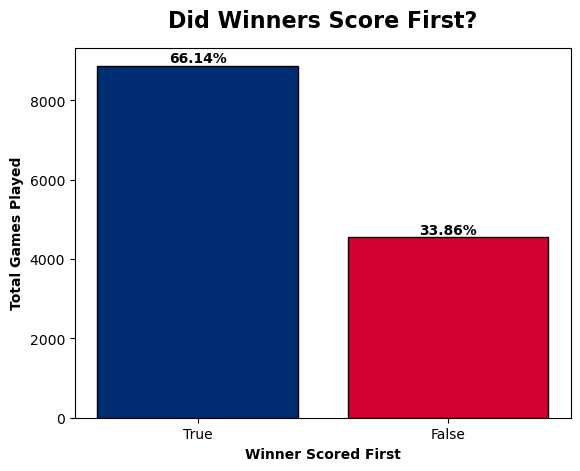

In [12]:
#Visualizing this data, creating the bar chart
plt.bar(['True', 'False'], count_score_wins.values, color = mlb_colors, edgecolor='black')

# Specifying labels and title
plt.xlabel('Winner Scored First', fontweight="bold")
plt.ylabel('Total Games Played', fontweight="bold")
plt.title('Did Winners Score First?', fontweight="bold", fontsize="16", pad=15)

#Adding the percentages of True and False to the chart
for i, count in enumerate(count_score_wins.values):
    percent = count / total_count_score_wins * 100
    plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom', fontweight="bold")

#Displaying the plot
plt.show()

# Did Teams that Won Have the Most Hits? <a class="anchor"  id="hit_first"></a>
Determining the number and percentage of games where the teams that won had the highest number of hits and visualizing the results.

In [13]:
#Whether winners had the most hits
count_hit_wins = games['winner_most_hits'].value_counts()

#Total games played
total_count_hit_wins = count_hit_wins.sum()

#Viewing the results
pd.DataFrame(data=count_hit_wins)

,winner_most_hits
True,9765
False,3656


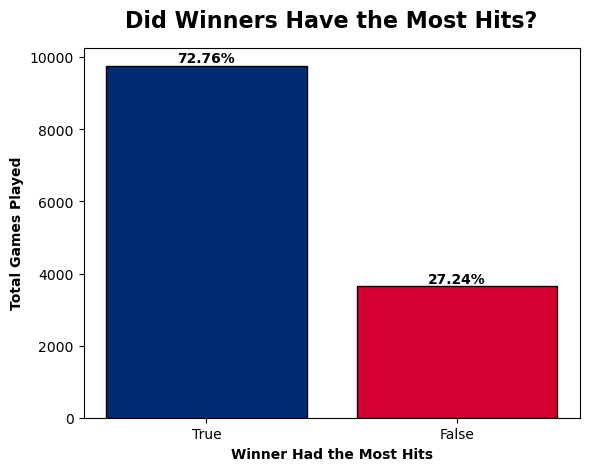

In [14]:
#Visualizing this data, creating a bar chart
plt.bar(['True', 'False'], count_hit_wins.values, color = mlb_colors, edgecolor='black')

# Specifying labels and title
plt.xlabel('Winner Had the Most Hits', fontweight="bold")
plt.ylabel('Total Games Played', fontweight="bold")
plt.title('Did Winners Have the Most Hits?', fontweight="bold", fontsize="16", pad=15)

#Adding the percentages of True and False to the chart
for i, count in enumerate(count_hit_wins.values):
    percent = count / total_count_hit_wins * 100
    plt.text(i, count, f'{percent:.2f}%', ha='center', va='bottom', fontweight="bold")

# Displaying the plot
plt.show()

#### Comparing wins based on whether the team scored first or had the most hits, there were more instances where the winners had the highest number of hits. Let's focus on hits for the rest of this analysis!

# Are Results Different for Each Team? <a class="anchor"  id="team"></a>

Determining whether winners who had the highest number of hits were different for each team. 

#### Wins and losses for each team

First, let's first look at the overall wins and losses record for each team.

In [15]:
#Creating a new dataframe with the winners and losers
win_loss_data = {'wins': games['winner'], 'losses': games['loser']}
win_loss_data_df = pd.DataFrame(win_loss_data)

#Counting the number of wins and losses per team
win_counts = win_loss_data_df['wins'].value_counts()
loss_counts = win_loss_data_df['losses'].value_counts()

#Calculating and appending the percent wins for each team
percent_wins = []
for w, l in zip(win_counts, loss_counts):
    percent_wins.append(round(w/(w+l) * 100, 2))
    
#Calculating and appending the percent losses for each team
percent_loss = []
for w, l in zip(win_counts, loss_counts):
    percent_loss.append(round(l/(w+l) * 100, 2))
    
#Creating a new dataframe combining the counts and percentages
team_win_loss_records = pd.DataFrame({
    'wins': win_counts,
    'losses': loss_counts,
    'percent_wins': percent_wins,
    'percent_losses': percent_loss
})

#Sorting the combined_data dataframe by percent_wins in descending order
team_win_loss_records = team_win_loss_records.sort_values('percent_wins', ascending=False)

#Resetting the index and renaming the index column as 'team'
team_win_loss_records = team_win_loss_records.reset_index().rename(columns={'index':'team'})

#Displaying the combined data
team_win_loss_records

,team,wins,losses,percent_wins,percent_losses
0,ATL,479,436,52.69,47.31
1,ARI,410,474,52.36,47.64
2,CHC,501,411,51.20,48.80
3,BOS,517,392,51.09,48.91
4,BAL,344,536,51.02,48.98
5,CHW,418,471,50.71,49.29
6,CIN,393,489,50.51,49.49
7,HOU,569,384,50.42,49.58
8,DET,365,511,50.42,49.58
9,COL,430,452,50.26,49.74


#### Games where the winner had the most hits by each team

In [16]:
#Whether the winner had the most hits, grouping by team
#Resetting the index so the final column is 'counts'
count_most_hits_team = games.groupby('winner')['winner_most_hits'].value_counts().reset_index(name='counts')

# Renaming the 'winner' column to 'team'
count_most_hits_team = count_most_hits_team.rename(columns={'winner': 'team'})

#Viewing the results
pd.DataFrame(data=count_most_hits_team)

,team,winner_most_hits,counts
0,ARI,True,296
1,ARI,False,114
2,ATL,True,348
3,ATL,False,131
4,BAL,True,248
5,BAL,False,96
6,BOS,True,391
7,BOS,False,126
8,CHC,True,378
9,CHC,False,123


In [17]:
# Merging the dataframe for total wins above and wins based on having the total number of hits
team_percents = count_most_hits_team[count_most_hits_team['winner_most_hits'] == True][['team','counts']].merge(team_win_loss_records[['team','wins']], on='team')

#Calculating the percentage of true values for each team
team_percents['percent_true'] = team_percents['counts'] / team_percents['wins'] * 100

#Sorting the dataframe by the percentage of true values in descending order
team_percents = team_percents.sort_values('percent_true', ascending=False)

#Rounding to two decimal places
team_percents = team_percents.round(decimals=2)

#Viewing the results, only want to see the team and percent column
team_percents[['team', 'percent_true']]

,team,percent_true
10,HOU,81.20
5,CHW,77.51
29,WSH,76.41
14,MIA,75.66
3,BOS,75.63
4,CHC,75.45
6,CIN,75.06
28,TOR,74.37
18,NYY,74.00
7,CLE,73.29


# Bivariate Analysis <a class="anchor"  id="biv"></a>
Using a bivariate analysis to understand the correlation between wins overall and wins due to having the highest number of hits. In other words, are the teams that have more wins due to having the highest number of hits more likely to have more wins overall?


In [18]:
#Creating a new dataframe with overall wins and wins due to the most hits
combined_data = pd.DataFrame(team_percents, columns=['team', 'percent_true'])

#Renaming the column 'percent_true to 'percent_wins_most_hits'
combined_data = combined_data.rename(columns={'percent_true': 'percent_wins_most_hits'})

#Adding the percent_wins from the overall wins/loss record into the dataframe
wins_team = []
for i in team_win_loss_records['percent_wins']:
    wins_team.append(i)
combined_data['percent_wins'] = wins_team

#Viewing the results
combined_data

,team,percent_wins_most_hits,percent_wins
10,HOU,81.20,52.69
5,CHW,77.51,52.36
29,WSH,76.41,51.20
14,MIA,75.66,51.09
3,BOS,75.63,51.02
4,CHC,75.45,50.71
6,CIN,75.06,50.51
28,TOR,74.37,50.42
18,NYY,74.00,50.42
7,CLE,73.29,50.26


In [19]:
#Calculating statistical data for combined_data 
combined_data.describe()

,percent_wins_most_hits,percent_wins
count,30.000000,30.000000
mean,72.604333,49.899333
std,3.111165,1.022997
min,66.830000,48.380000
25%,70.810000,49.172500
50%,72.585000,49.550000
75%,74.277500,50.420000
max,81.200000,52.690000


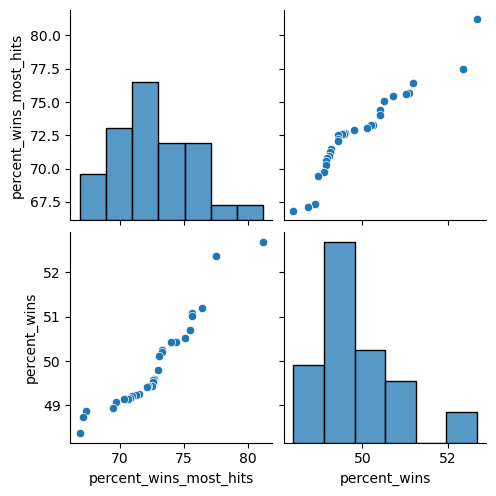

In [20]:
#Visualizing the relationship between wins overall and wins due to having the most hits
sns.pairplot(combined_data)

plt.show()

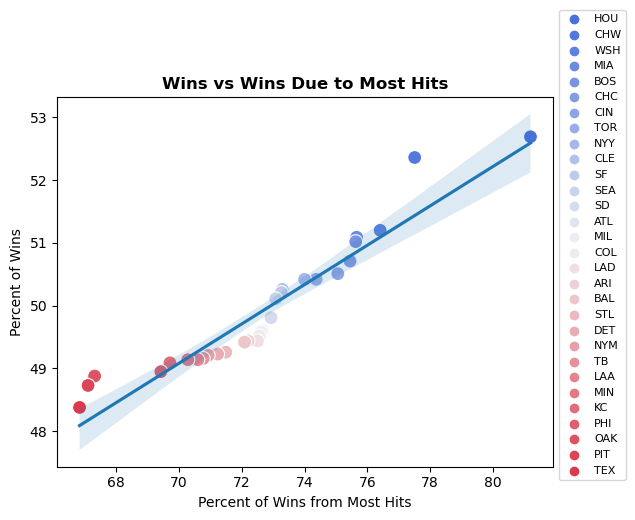

In [21]:
#Visualizing by team
graph = sns.scatterplot(x="percent_wins_most_hits", y="percent_wins", data=combined_data, hue='team', legend=True, s=100, palette=mlb_palette)

#Adding a trendline
sns.regplot(x="percent_wins_most_hits", y="percent_wins", data=combined_data, scatter=False)

#Customizing x and y axis labels
graph.set(xlabel='Percent of Wins from Most Hits', ylabel='Percent of Wins')

#Adjusting the size of the legend
plt.legend(loc="center left", bbox_to_anchor=(1, 0.6), prop={'size': 8})

#Adding a title
plt.title("Wins vs Wins Due to Most Hits", fontweight="bold")

plt.show()

In [22]:
# Calculating the R^2 value of the line
x = combined_data["percent_wins_most_hits"]
y = combined_data["percent_wins"]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value**2
r_squared = r_squared.round(3)

r_squared

0.907

In [23]:
#Calculating the correlation of Percent of Wins From Most Hits and Percent of Wins

# Pearson's r correlation
r = x.corr(y)
rounded_r = round(r, 3)

rounded_r

0.952

In [24]:
# Spearman's rho correlation
r = x.corr(y, method='spearman')  
rounded_r = round(r, 3)

rounded_r

1.0

In [25]:
# Kendall's tau correlation
r = x.corr(y, method='kendall')   
rounded_r = round(r, 3)

rounded_r

0.997

# Conclusions <a class="anchor"  id="con"></a>

This analysis used MLB data to answer that winners are more likely to win because they had the highest number of hits versus scoring first. 

When it was identified that having the highest number of hits was more likely to result in a win, this data was grouped by team to identify if there were differences by team. This analysis showed that there is a strong positive correlation between winning due to having the most hits and winning overall.

For softball and baseball teams looking to improve their win record, start by focusing on the number of hits!

